# Проект Телеком 

## Исследовательский анализ данных по проекту

### Описание задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. 

Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Есть следующие файлы - contract.csv, internet.csv, phone.csv, personal.csv

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Для начала напишем наш план работ по проекту (в 1-2 предложения необходимые шаги для получения нужного результата для заказчика)

### План работ по проекту:

1. Загрузим и проанализируем данные. Посмотрим тип данных, пропуски, дубликаты(хотя скорее всего customerID уникальное значение). 

2. Займемся углубленным анализов данных, посмотрим на влияние признаков друг на друга и на таргет. Создадим новые признаки при необходимости, у нас задача классификации - посмотри баланс классов.

3. Приготовим наши данные к работе моделей - разделим на данные на выборки (сделаем размер тестовой выборки - 0.2). Возьмем 2-4 модели на выбор. Гиперпараметры для теста подберем кросс-валидацией. Выберем лучшую модель и запустим ее с выбранными гиперпарматрами на тестовой выборке. Необходимо достичь результат значения >= 0.85 на метрике AUC-ROC.

4. Сделаем отчет о нашем исследовании, в который включим графики и результаты тестирования моделей. 

### Анализ данных и выводы

Импортируем необходимые библиотеки

In [94]:
import pandas as pd
# Позднее добавлю остальные библиотеки в данное поле

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
import time

In [95]:
pip install phik==0.10.0

Note: you may need to restart the kernel to use updated packages.


In [96]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

Прочитаем наши файлы csv

In [97]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')

По очереди выведем информацию по каждой таблице методами info(), describe(), head(). Также проанализируем полученные результаты ниже

In [98]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [99]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [100]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [101]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [102]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,5433-KYGHE,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [103]:
internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [104]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [105]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,1755-RMCXH,No
freq,1,3390


In [106]:
phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [107]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [108]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [109]:
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


### Выводы по первичному анализу данных
Небольшие выводы по итогу просмотра данных и их анализу:

- У нас 4 таблицы, которые объединены одним общим полем customerID, по которому можно будет соединить интересующие нас признаки в единую таблицу

- В остальных таблицах у нас данные по договору (contract), данные по клиенту (personal), подключена ли телефоная и какого типа (phone), и также с интернетом (internet)

- На данный момент не вижу таргета в данных(фактически он есть - но в неудобной для ML форме). У нас задача классификации - уйдет ли клиент или нет (стандартные 0-1). Будем использовать метрики классификации (по заданию AUC-ROC) . Таргет можно создать через поле с датой окончания договора в таблице contract

- Также есть 2 таблицы - интернет и телефония. Есть клиенты кто пользуется и той и той услугой от компании. Есть кто пользуется кто-то одной. При объединении будут пропуски, недопустимые в моделях. Наших данных мало для удаления данных - будем ставить заглушку, скорее всего. 

### Вопросы по проекту и данным

1. Можно ли в данном проекте попробовать модели сначала на минимально измененых данных, без генерации новых признаков на 1-2 моделях и далее уже с этими же моделями провести анализ и попробовать снова?

2. Все остальные вопросы вроде разобрали на вебинаре, пока все понятно

## Дополнительный анализ данных и их подготовка. Выбор моделей под метрику AUC-ROC

### Дополнительный анализ данный

Для начала сделаем таргет понятный для наших моделей - напишем функцию target

In [110]:
# Сделаем следующие значения 0 - клиент остался в рамках договора, 1 - клиент прекратил работать с компанией в рамках договора
def target(func):
    if 'No' in func:
        return 0
    else:
        return 1
    
contract['target'] = contract['EndDate'].apply(target)

In [111]:
#Посмотрим результат методом head()
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [112]:
contract['target'].value_counts()

0    5174
1    1869
Name: target, dtype: int64

Построим график

0    0.73463
1    0.26537
Name: target, dtype: float64


<AxesSubplot:>

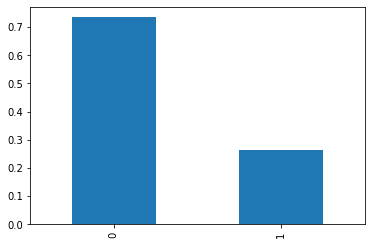

In [113]:
class_frequency = contract['target'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

По итогу видим дисбаланс классов - ушло клиентов в 3 раза меньше, чем осталось. Будем думать как проработать этот дисбаланс в самих моделях

Создадим новую фичу, количество месяцев, которые клиент платил за услуги компании. Для этого переведем тип данных в столбце TotalCharges в float64

In [114]:
contract['TotalCharges']=pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [115]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   target            7043 non-null   int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 495.3+ KB


In [116]:
contract['month'] = (contract['TotalCharges']/contract['MonthlyCharges']).round()

In [117]:
contract.head(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,month
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,33.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,2.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,44.0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,2.0
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,1,8.0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0,22.0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,0,10.0
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,1,29.0
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,0,62.0


Вторым пунктом помимо месяца - добавим количество дней, которыми пользовался клиент пользовался услугами компании. Для этого переведем даты в формат datetime, заменим пропуски 

In [118]:
contract['EndDate']=pd.to_datetime(contract['EndDate'], dayfirst=True, errors='coerce')
contract['BeginDate']=pd.to_datetime(contract['BeginDate'], dayfirst=True, errors='coerce')
contract['EndDate'].fillna('2020-02-01', inplace=True)
contract['EndDate']=pd.to_datetime(contract['EndDate'], dayfirst=True, errors='coerce')

In [119]:
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   target            7043 non-null   int64         
 9   month             7032 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 550.4+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,month
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,1.0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,33.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2.0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,44.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2.0


Создадим признак - дни. Решим что позже удалить, месяц или дни

In [120]:
contract['days'] = contract['EndDate'] - contract['BeginDate']

In [121]:
contract['days'] = contract['days'].dt.components.days

In [122]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   target            7043 non-null   int64         
 9   month             7032 non-null   float64       
 10  days              7043 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(2), object(4)
memory usage: 605.4+ KB


In [123]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,month,days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,1.0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,33.0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2.0,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,44.0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2.0,61


Следующим пунктом объединим таблицы для большего числа признаков 

In [124]:
df1=pd.merge(contract, internet, how='left', on='customerID', 
             left_on=None, right_on=None, left_index=False, right_index=False)
            
df2=pd.merge(df1, phone, how='left', on='customerID', 
            left_on=None, right_on=None, left_index=False, right_index=False) 
# Добавил данные из таблицы personal в общую таблицу
df=pd.merge(df2, personal, how='left', on='customerID', 
            left_on=None, right_on=None, left_index=False, right_index=False) 

Проверим результат нашего объединения

In [125]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   target            7043 non-null   int64         
 9   month             7032 non-null   float64       
 10  days              7043 non-null   int64         
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null   object        
 14  DeviceProtection  5517 n

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,month,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,1.0,...,Yes,No,No,No,No,NaN,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,33.0,...,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2.0,...,Yes,No,No,No,No,No,Male,0,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,44.0,...,No,Yes,Yes,No,No,NaN,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2.0,...,No,No,No,No,No,No,Female,0,No,No
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,1,8.0,...,No,Yes,No,Yes,Yes,Yes,Female,0,No,No
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0,22.0,...,Yes,No,No,Yes,No,Yes,Male,0,No,Yes
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.90,0,10.0,...,No,No,No,No,No,NaN,Female,0,No,No
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,1,29.0,...,No,Yes,Yes,Yes,Yes,Yes,Female,0,Yes,No
9,6388-TABGU,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),56.15,3487.95,0,62.0,...,Yes,No,No,No,No,No,Male,0,No,Yes


После объединения всех 3 необходимых таблиц мы имеем некоторое количество пропусков и надо с ними разобраться до начала работы над моделями

Пропуски возникли по причине, что одни клиенты пользуются только услугами телефонии, а другие клиенты пользуются услугами только интернета

Некоторые признаки можем также удалить - они нам не нужны, например customerID, BeginDate, EndDate, остальные данные можно закодировать после разделения выборок. Также удалим созданный столбец с месяцами, он будет сильно коррелировать со столбцом с днями


In [126]:
df = df.drop(['customerID', 'BeginDate', 'EndDate','month', 'DeviceProtection', 'PaymentMethod'], axis=1)

Далее разберемся с пропусками (заодно проверим удаление ненужных столбцов)

In [127]:
df.isna().sum()

Type                   0
PaperlessBilling       0
MonthlyCharges         0
TotalCharges          11
target                 0
days                   0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
dtype: int64

Пропуски в интернете и телефонии заполним заглушкой (нулевым значением - так как будем приводить признаки к 0-1, где 0 означает отсутствие услуги у пользователя) и предварительно удалим 11 пропусков в нашей созданной фиче с оплатой за месяц и общей оплатой

In [128]:
df.dropna(subset = ['TotalCharges'], inplace = True)

In [129]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2416
Name: InternetService, dtype: int64

In [130]:
# В столбце, который мы рассмотрели выше - есть 2 значения DSL и Fiber optic. Пропуски заменим на No
df['InternetService']=df['InternetService'].fillna('No')

# В остальных признаках с пропусками есть четкое разделение Yes - услуга подключена, No - услуга не подключена
# у клиентов, которые пользуются телефонией без интернета при слиянии таблиц образовались пропуски (и наоборот)
# Для таких пропусков заменим Nan на NO - услуга этому клиенту не предоставляется
df['OnlineSecurity']=df['OnlineSecurity'].fillna('No')
df['OnlineBackup']=df['OnlineBackup'].fillna('No')
#df['DeviceProtection']=df['DeviceProtection'].fillna('No')
df['TechSupport']=df['TechSupport'].fillna('No')
df['StreamingTV']=df['StreamingTV'].fillna('No')
df['StreamingMovies']=df['StreamingMovies'].fillna('No')
df['MultipleLines']=df['MultipleLines'].fillna('No')

Проверим на пропуски наш общий датасет после всех преобразований

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   MonthlyCharges    7032 non-null   float64
 3   TotalCharges      7032 non-null   float64
 4   target            7032 non-null   int64  
 5   days              7032 non-null   int64  
 6   InternetService   7032 non-null   object 
 7   OnlineSecurity    7032 non-null   object 
 8   OnlineBackup      7032 non-null   object 
 9   TechSupport       7032 non-null   object 
 10  StreamingTV       7032 non-null   object 
 11  StreamingMovies   7032 non-null   object 
 12  MultipleLines     7032 non-null   object 
 13  gender            7032 non-null   object 
 14  SeniorCitizen     7032 non-null   int64  
 15  Partner           7032 non-null   object 
 16  Dependents        7032 non-null   object 


In [132]:
df.head()

,Type,PaperlessBilling,MonthlyCharges,TotalCharges,target,days,InternetService,OnlineSecurity,OnlineBackup,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
0,Month-to-month,Yes,29.85,29.85,0,31,DSL,No,Yes,No,No,No,No,Female,0,Yes,No
1,One year,No,56.95,1889.50,0,1036,DSL,Yes,No,No,No,No,No,Male,0,No,No
2,Month-to-month,Yes,53.85,108.15,1,61,DSL,Yes,Yes,No,No,No,No,Male,0,No,No
3,One year,No,42.30,1840.75,0,1371,DSL,Yes,No,Yes,No,No,No,Male,0,No,No
4,Month-to-month,Yes,70.70,151.65,1,61,Fiber optic,No,No,No,No,No,No,Female,0,No,No


Проверили результат - у нас нет пропусков в данных. Следующим шагом сделам кодировку данных, обратим все наши Yes/No в понятные 0-1

Проверим оставшиеся столбцы на мультеколлениарность с нашим таргетом перед обучением моделей с помощью phik

In [133]:
df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'days', 'SeniorCitizen']


,Type,PaperlessBilling,MonthlyCharges,TotalCharges,target,days,InternetService,OnlineSecurity,OnlineBackup,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
Type,1.000000,0.106151,0.388557,0.507638,0.251283,0.666958,0.503776,0.152239,0.099016,0.180169,0.067123,0.070375,0.065750,0.000000,0.085800,0.179294,0.146126
PaperlessBilling,0.106151,1.000000,0.467547,0.205050,0.295194,0.000000,0.231145,0.000000,0.196937,0.055354,0.344114,0.325351,0.253299,0.000000,0.241715,0.010489,0.170650
MonthlyCharges,0.388557,0.467547,1.000000,0.762904,0.359623,0.409989,0.919005,0.550855,0.629276,0.576163,0.835680,0.833111,0.676393,0.005522,0.304546,0.204575,0.182283
TotalCharges,0.507638,0.205050,0.762904,1.000000,0.280973,0.842068,0.507972,0.545578,0.656039,0.567056,0.660452,0.666068,0.606423,0.000000,0.148024,0.424655,0.118247
target,0.251283,0.295194,0.359623,0.280973,1.000000,0.473761,0.195860,0.264645,0.127052,0.254678,0.096903,0.093088,0.059462,0.000000,0.232897,0.232215,0.252268
days,0.666958,0.000000,0.409989,0.842068,0.473761,1.000000,0.012927,0.425021,0.466439,0.424046,0.361518,0.368627,0.433857,0.000000,0.028044,0.492490,0.214108
InternetService,0.503776,0.231145,0.919005,0.507972,0.195860,0.012927,1.000000,0.240905,0.233205,0.239149,0.272629,0.272562,0.225602,0.000000,0.160452,0.000000,0.107328
OnlineSecurity,0.152239,0.000000,0.550855,0.545578,0.264645,0.425021,0.240905,1.000000,0.429646,0.527759,0.271134,0.289137,0.152640,0.016788,0.056897,0.222040,0.124648
OnlineBackup,0.099016,0.196937,0.629276,0.656039,0.127052,0.466439,0.233205,0.429646,1.000000,0.444385,0.427288,0.417200,0.311389,0.007277,0.102206,0.219762,0.031464
TechSupport,0.180169,0.055354,0.576163,0.567056,0.254678,0.424046,0.239149,0.527759,0.444385,1.000000,0.421497,0.425211,0.155502,0.000000,0.092485,0.186312,0.096565


Смотря по таблице мультеколлениарности есть влияние 2 признаков на наш таргет - это признак MonthlyCharges (0.35) и наш созданный days (0.47).

Думаю их оставить - корреляция конечно выше чем у других признаков - но прям прямой зависимости нет

### Разделение выборок и их кодировка методом OHE

Выделим наш таргет и признаки

In [134]:
target=df['target']
features=df.drop('target', axis=1)

Сделаем разделение на тест и треин - в размере 80% тренировочная выборка и 25% тестовая

In [135]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.20, random_state=190922)

Проверим размер выборок для моделей

In [136]:
print(features_train.shape)
print(features_test.shape)

(5625, 16)
(1407, 16)


Все корректно - выборок будет 2 - train и test из-за недостатка данных

Закодируем в тренировочной выборки наши признаки для улучшения работы модели методом OHE, чтобы не попасть в дамми ловушку уберем первый столбец.

In [137]:
features_train_ohe=pd.get_dummies(features_train, drop_first=True)
features_test_ohe=pd.get_dummies(features_test, drop_first=True)

In [138]:
features_train_ohe.head(10)

,MonthlyCharges,TotalCharges,days,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,gender_Male,Partner_Yes,Dependents_Yes
1710,82.75,417.75,153,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
3620,50.00,1750.85,1006,1,0,0,1,0,0,0,1,1,1,0,0,1,1,0
908,19.95,170.90,245,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2251,69.35,712.25,337,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0
5573,69.85,69.85,31,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3598,46.30,46.30,31,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2101,99.20,3754.60,1125,0,1,0,1,1,0,1,0,1,0,1,1,0,1,0
1857,58.90,3857.10,1979,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0
1389,94.25,3217.55,1033,1,0,0,1,1,0,0,1,0,0,1,1,0,1,0
3465,45.90,199.75,123,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


Сработало - отлично, проверим еще раз размер выборок на соответсвие друг другу для обучения моделей

In [139]:
print(features_train_ohe.shape)
print(features_test_ohe.shape)

(5625, 18)
(1407, 18)


In [140]:
features_train_ohe_lin = features_train_ohe
features_test_ohe_lin = features_test_ohe

In [141]:
print(features_train_ohe_lin.shape)
print(features_test_ohe_lin.shape)

(5625, 18)
(1407, 18)


Следующим шагом разберемся с числовыми признаками - сделаем их одинаково важными для модели с учетом разброса данных с помощью StandartScaler для Линейной модели

In [142]:
numeric=['MonthlyCharges', 'TotalCharges', 'days']

In [143]:
scaler = StandardScaler()
scaler.fit(features_train_ohe_lin[numeric])
features_train_ohe_lin[numeric] = scaler.transform(features_train_ohe_lin[numeric])
features_test_ohe_lin[numeric] = scaler.transform(features_test_ohe_lin[numeric])

Приступаем к обучению моделей

### Обучение и выбор модели для финального тестирования

#### Выбор моделей и работа с ними 

Для нашего проекта выберем 3 модели - DesicionTreeClassifier, LinearClassifier, RandomForestClassifier

#### Модель RandomForestClassifier

In [144]:
model_for = RandomForestClassifier(random_state=190922, class_weight='balanced')

In [145]:
parametrs = { 'n_estimators': range (30, 61, 10),
              'max_depth': range (7,14, 2),
              'min_samples_leaf': range (5,8),
              'min_samples_split': range (6,10,2) }

In [146]:
%%time
grid_forest = GridSearchCV(model_for, parametrs, cv=5, verbose=2, scoring='roc_auc')
grid_forest.fit(features_train_ohe, target_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=6, n_estimators=30; total time=   0.1s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=6, n_estimators=30; total time=   0.1s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=6, n_estimators=30; total time=   0.1s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=6, n_estimators=30; total time=   0.1s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=6, n_estimators=30; total time=   0.1s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=6, n_estimators=40; total time=   0.1s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=6, n_estimators=40; total time=   0.1s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=6, n_estimators=40; total time=   0.1s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=6, n_estimators=40; total time=   0.1s
[CV] END max_depth=7, min_samples_leaf=5, min_s

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=190922),
             param_grid={'max_depth': range(7, 14, 2),
                         'min_samples_leaf': range(5, 8),
                         'min_samples_split': range(6, 10, 2),
                         'n_estimators': range(30, 61, 10)},
             scoring='roc_auc', verbose=2)

In [147]:
grid_forest.best_params_

{'max_depth': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 6,
 'n_estimators': 60}

In [148]:
grid_forest.best_score_

0.8594698075683128

In [149]:
forest_auc=grid_forest.best_score_

#### Модель LogisticRegression

In [150]:
model_lin=LogisticRegression(random_state=190922, solver='liblinear')

In [151]:
parametrs= {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

grid_lr = GridSearchCV(model_lin, parametrs, cv=5, scoring='roc_auc')

grid_lr.fit(features_train_ohe_lin, target_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=190922,
                                          solver='liblinear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [152]:
grid_lr.best_params_

{'C': 10.0, 'penalty': 'l2'}

In [153]:
grid_lr.best_score_

0.8433345236775718

In [154]:
lr_auc=grid_lr.best_score_

#### Модель DecisionTreeClassifier

In [155]:
model_destree = DecisionTreeClassifier(random_state=190922, class_weight='balanced')

In [156]:
parametrs = { 'max_depth': range (7,14, 2),
              'min_samples_leaf': range (5,8),
              'min_samples_split': range (6,10,2) }

In [157]:
%%time
grid_forest = GridSearchCV(model_destree, parametrs, cv=5, verbose=2, scoring='roc_auc')
grid_forest.fit(features_train_ohe, target_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV] END max_depth=7, min_samples_le

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=190922),
             param_grid={'max_depth': range(7, 14, 2),
                         'min_samples_leaf': range(5, 8),
                         'min_samples_split': range(6, 10, 2)},
             scoring='roc_auc', verbose=2)

In [158]:
grid_forest.best_params_

{'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 6}

In [159]:
grid_forest.best_score_

0.8397071080837077

In [160]:
destree=grid_forest.best_score_

#### Итоговые результаты моделей на кроссвалидации

In [161]:
after_cv = pd.DataFrame(
    {'model': ['RandomForrestClassifier', 'LogisticRegression', 'DecisionTreeClassifier'], 
     'AUC_ROC': [forest_auc, lr_auc, destree]})

In [162]:
after_cv

,model,AUC_ROC
0,RandomForrestClassifier,0.859470
1,LogisticRegression,0.843335
2,DecisionTreeClassifier,0.839707


Лучшей моделью стала RandomForrestClassifier (0.859470) - его и попробуем на тестовой выборке и посмотрим на метрику AUC-ROC. Также построим график

#### Тест модели и график AUC-ROC, важность признаков для модели

In [163]:
model_final = RandomForestClassifier(max_depth=9, min_samples_leaf=5, min_samples_split=6, n_estimators=60, random_state=190922)

In [164]:
%%time
model_final.fit(features_train_ohe, target_train)

CPU times: user 217 ms, sys: 42 µs, total: 217 ms
Wall time: 240 ms


RandomForestClassifier(max_depth=9, min_samples_leaf=5, min_samples_split=6,
                       n_estimators=60, random_state=190922)

In [165]:
%%time
prediction = model_final.predict(features_test_ohe)

CPU times: user 21.3 ms, sys: 131 µs, total: 21.4 ms
Wall time: 20 ms


In [166]:
accuracy_score(target_test, prediction)

0.8315565031982942

In [167]:
probabilities_valid_final = model_final.predict_proba(features_test_ohe)
probabilities_one_valid_final = probabilities_valid_final[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid_final)
roc_auc_score(target_test, probabilities_one_valid_final)

0.8666215230206348

Задача выполнена - наш AUC-ROC больше 0.85

Построим график нашей метрики. AUC-ROC это площадь под кривой в отношении истинно верных ответов (TPR) и ложно положительным ответам (FPR)

Text(0.5, 1.0, 'ROC-кривая модели RandomForrestClassifier')

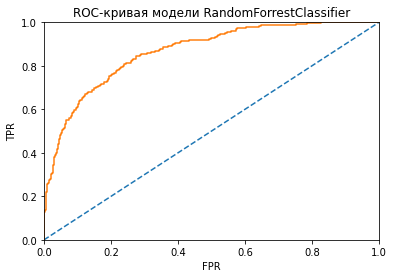

In [168]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая модели RandomForrestClassifier')

Также построим график важности признаков для нашей финальной модели RandomForrestClassifier

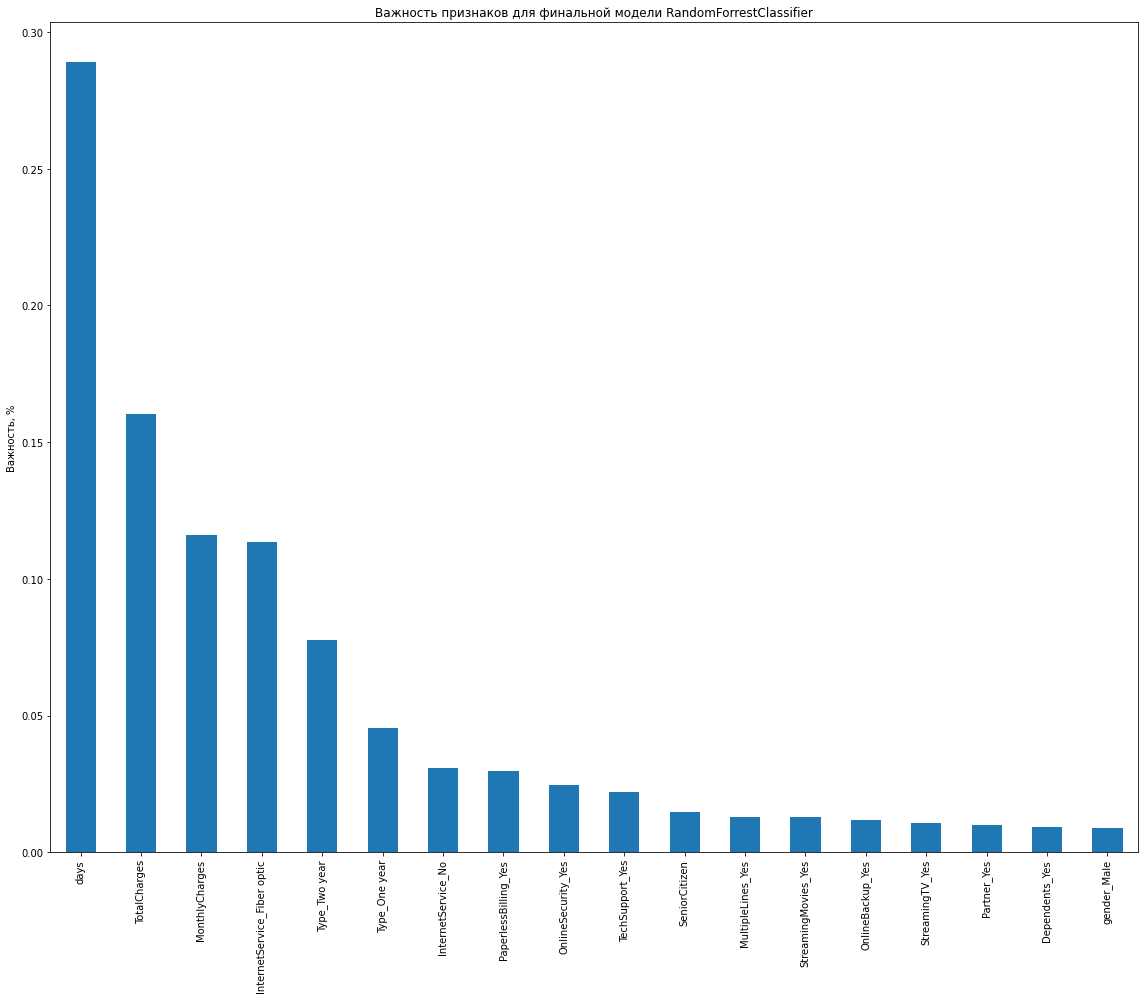

In [169]:
features_importance = pd.Series(model_final.feature_importances_,
                         features_train_ohe.columns)
fig, ax = plt.subplots(figsize=(16,14))
features_importance.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Важность признаков для финальной модели RandomForrestClassifier")
ax.set_ylabel('Важность, %')
fig.tight_layout()

#### Выводы по моделям и метрикам

- Были рассмотрены 3 модели DecisionTreeClassifier, RandomForrestClassifier, LogisticRegression 

- Наилучшую метрику AUC-ROC показала модель RandomForrestClassifier - 0.866. Финальная задача выполнена!

- Во всех моделях использовал подбор гиперпараметров для выбора лучшей модели на тестирование

- Для финальной метрики был построен график ROC кривой и график важности признаков для данной модели Features importance

- Часть признаков по данному графику очень важна для модели - месячный платеж, общая уплаченная сумма, количество дней,  

- Есть же часть признаков совершенно ненужных для модели - например тип подключения по сети интернет, стриминговое ТВ. Часть из них удалил согласно


## Отчет об исследовании и проделанной работе

### Повторим кратко нашу задачу и данные с которыми мы работали

#### Задача проекта Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов.

Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Есть следующие файлы - contract.csv, internet.csv, phone.csv, personal.csv

#### Описание исходных данных для проекта

В наших 4 файлах (contract.csv, internet.csv, phone.csv, personal.csv) есть все необходимые данные для решения данной задачи.

Рассмотрим каждый файл по отдельности

#### Contract.csv

Это основной файл для нашего проекта - в нем содержится самая важная метрика 'EndDate', а именно срок окончания договора. Поскольку этот столбец содержит данные в формате даты окончания договора, мною было принято решение создать на основании данного столбца свой новый таргет - 'target'. Где 1 - клиент ушел и 0 - клиент остался с компанией.

Помимо основной цели нашего исседования в данном файле содержится информация по способу оплаты для клиента, сроку заключения договора, месячному платежу, общей сумме оплат для клиента в рамках договора. 

Также следует отметить важный момент - в рамках создания удобного для машинного обучения таргета, был выявлен дисбаланс классов.

<AxesSubplot:>

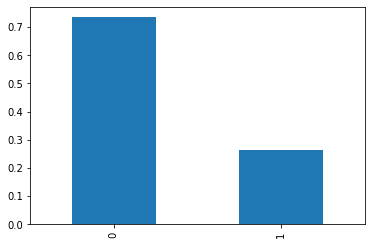

In [170]:
class_frequency.plot(kind='bar')

Cоотношение клиентов 3:1, ушло клиентов в 3 раза меньше, чем продолжило работу с компанией

In [171]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   target            7043 non-null   int64         
 9   month             7032 non-null   float64       
 10  days              7043 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(2), object(4)
memory usage: 605.4+ KB


#### Phone.csv

Данный файл представляет собой таблицу из 2 полей - наш общий customerId и второй столбец - какой линией пользуются абоненты, мультиканальной или одноканальной. Отдельно отмечу, что не все абоненты пользуются телефонией от компании

In [172]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


#### Personal.csv

В данной таблице идет описание личных особенностец каждого клиента - пол, семейное положение, является ли клиент пенсионером и есть ли у клиента дети, либо кто-то на иждивении. Связь с остальными таблицами по customerID

In [173]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


#### Internet.csv

Таблица internet самая большая - тут собраны те клиенты, кто пользуется услугами интернета от компании. В данной таблице есть такие поля как - тип подключения к сети, различные настройки, подключени ли антивирус и прочее

In [174]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


### Соответствие нашему плану работ

В самом начале работ по проекту был предложен план действия для достижения результата в заданные сроки. В целом удалось сохранить структуру плана в нашей работе и выполнить все ключевые пункты прописанные в нем.
Кратко напишу пункты плана:

1 - Первичное знакомство с данными, посмотреть тип данных, пропуски, как выглядит таблица - Пункт выполнен!

2 - Более глубокий анализ данных, возможно создание дополнительных признаков, объединим все таблицы в одну, заполним пропуски, обязательно посмотрим на влияние признаков друг на друга (чтобы не было утечки целевого признака). Выделим таргеты и признаки, разделим наши данные на 2 выборки - Пункт выполнен!

3 - Переходим к работе с моделями - были выбраны 3 модели RandomForrestClassifier, LogisticRegression, DecisionTreeClassifier. Для этих моделей потребовалось закодировать наши признаки методом OHE, также для линейной модели сделал масштабирование признаков. В моделях использовал встроенные функции борьбы с дисбалансом классов. - Пункт выполнен!

4 - Формирование отчета по итогам проделанной работы. 

В данный момент пишу отчет. Критических отклонений от плана не выявлено!

### Особенности проекта, ключевые шаги и сложности, процесс предобработки данных

#### Особенности проекта и предобработка данных

В рамках работы над проектом были и сложности и достаточно легкие моменты. В данной абзаце опищу особенности проекта. 

- В первую очередь это состав данных для проекта - 4 отдельных файла, объединенные общим ключом - полем customerID. 

- Второе, в рамках проекта нет нужного для машинного обучения таргета - его нужно создавать путем добавления нового столбца по исходным данным

- В рамках работы над проектом много времени нужно уделить обработке признаков, необходимая метрика 0.85 sp достигается за счет хорошей предобработки признаков и работы с гиперпараметрами модели

- Данные хранятся в 4 разных таблицах, при их объединении в одну возникают пропуски, которые недопустимы для ML. Было решено действовать по алгоритму - объединить таблицы и заполнить их заглушкой ('No'). Так мы не изменяя структуру данных даем модели понять что человек этим не пользуется

- Во время исследования данных было принято решение создать 2 новых признака - месяц и дней, по количеству соответсвенно с даты заключения договора и до даты расторжения (дату расторжения оставшихся клиентов проставил последнюю по ТЗ)

#### Сложности проекта и их решение

В проекте были следующие сложности:

- Было много разных типов данных у столбцов - это сложность успешно решена заменой типа данных в столбцах

- При слиянии таблиц обнаруживались пропуски в тех местах, где у клиентов подключена или телефония или интернет. Заполнять пришлось заглушками для дальнейшего исследования

- Использовал стандартные модели, для них необходимо было закодировать данные, а для линейной модели также масштабировать данные

### Используемые модели и их гиперпараметры

В проекте были использованы 3 модели - DecisionTreeClassifier, RandomForrestClassifier, LogisticRegression

Для каждой модели гиперпараметры подбирались с помощью подбора GridSearch с кросс-валидацией (разбиением данных на 5 выборок)

Также на этапе подбора гиперпараметров мы искали лучшую метрику - AUC-ROC. 

Сводная таблица наших моделей на этапе подбора гиперпараметров и кросс-валидации

In [175]:
after_cv

,model,AUC_ROC
0,RandomForrestClassifier,0.859470
1,LogisticRegression,0.843335
2,DecisionTreeClassifier,0.839707


Лучшей моделью на этапе кросс-валидации стала RandomForrestClassifier с результатом AUC-ROC = 0.859470

Данную модель мы будем тестировать на тестовой выборке со следующими гиперпараметрами:

{'max_depth': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 6,
 'n_estimators': 60}

Расшифруем:

- 'n_estimators': 60 - Количество деревьев : 60

- 'max_depth': 9 - Максимальная глубина деревьев : 9

- 'min_samples_split': 6 - Минимальное число объектов, при котором выполняется расщепление : 6

- 'min_samples_leaf': 5 - Ограничение на число объектов в листьях : 5    

Данные гиперпараметры дали нам следующий результат метрики AUC-ROC на финальном тестировании - 0.8666215230206348

Вторичная метрика accuracy на тестировании дала следующий результат - 0.8315565031982942

### Анализ важности признаков для финальной модели

Построим график анализа важности признаков для модели - отсортируем его по убыванию и проанализируем

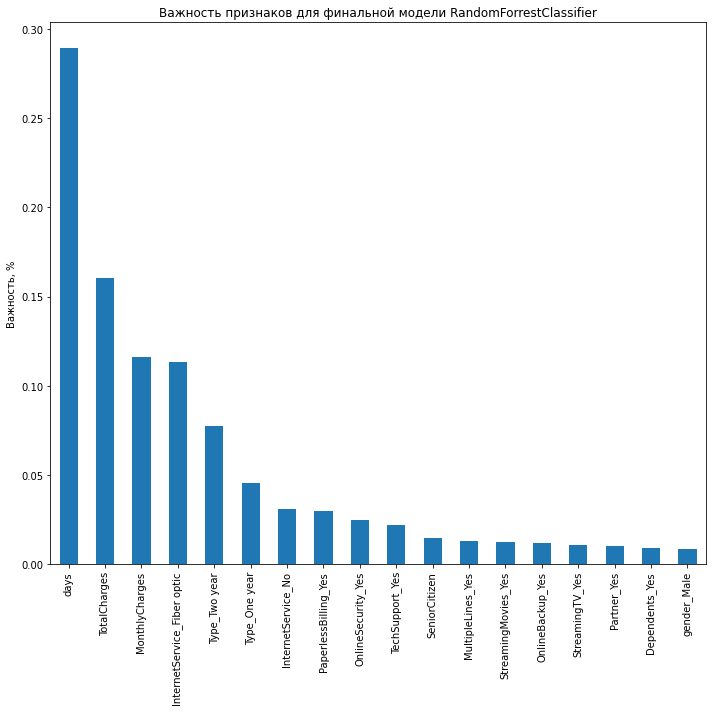

In [176]:
features_importance = pd.Series(model_final.feature_importances_,
                         features_train_ohe.columns)
fig, ax = plt.subplots(figsize=(10,10))
features_importance.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Важность признаков для финальной модели RandomForrestClassifier")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Анализ признаков

- Самым важным признаком оказался наш созданный признак days - количестов дней с момента заключению договора до его разрыва (или до точки X, где заканчивается наш временной промежуток, что означает что клиент остался с компанией)

- Также важные признаки это месячный платеж и общая сумма платежа, что логично, компаний связи и интернет провайдеров много, выбор есть, большинство клиентов смотрят именно за ценообразованием и стоимостью услуг

- Важным признаком отмечен тип подключения интернет соединения, опять же логично, от него зависит качество сигнала и скорость интернета

- Далее идут договорные признаки - срок заключения договора и оплаты (раз в месяц, раз в год и раз в 2 года)

- Самыми не важными признаками являются различные опции для пользователей интернет соединения от компании и личные данные пользователей. Каким бы не был человек, молодым или пенсионером - самое важное, это стоимость и четкое выполнение своих обязательств компанией